# Naive Bayes classifier for Fake News recognition
## Authors
+ [Paolo Zinesi](https://github.com/PaoloZinesi)
+ [Nicola Zomer](https://github.com/NicolaZomer)

## Overview
Fake news are defined by the New York Times as ”a made-up story with an intention to deceive”, with the intent to confuse or deceive people.
They are everywhere in our daily life, and come especially from social media platforms and applications in the online world.
Being able to distinguish fake contents form real news is today one of the most serious challenges facing the news industry.

Naive Bayes classifiers are powerful algorithms that are used for text data analysis and are connected to classification tasks of text in multiple classes.

The goal of the project is to implement a Multinomial Naive Bayes classifier in R and test its performances in the classification of social media posts.
The suggested [data set](https://www.kaggle.com/datasets/anmolkumar/fake-news-content-detection?select=train.csv) is available on Kaggle.

In [1]:
# tidyverse
library(tidyverse)

# NLP and statistics
library(NLP)
library(tm)
library(e1071)
library(gmodels)
library(stopwords)

# wordcloud
library(wordcloud)
library(tm)

# others
library(gridExtra)
library(latex2exp)
library(glue)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate



Attaching package: ‘stopwords’


The following object is masked from ‘package:tm’:

    stopwords


Loading required package: RColorBrewer


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Pre-processing

## Dataset description
- Train.csv: 10240 rows x 3 columns (inlcudes Labels columns as target) <br>
- Test.csv:  1267 rows x 2 columns (does not include the Labels column)

As the documents in file test.csv are not labeled, we further divide the data in train.csv in training set and test set, which are used respectively to train the model and evaluate its effectiveness. 

In [2]:
train.data.raw <- read_csv('data/train.csv')
test.data.raw  <- read_csv('data/test.csv')

head(train.data.raw)
head(test.data.raw)

Rows: 10240 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Text, Text_Tag
dbl (1): Labels

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1267 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Text, Text_Tag

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Labels,Text,Text_Tag
<dbl>,<chr>,<chr>
1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
2,The economic turnaround started at the end of my term.,"economy,jobs"
5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


Text,Text_Tag
<chr>,<chr>
Building a wall on the U.S.-Mexico border will take literally years.,immigration
Wisconsin is on pace to double the number of layoffs this year.,jobs
Says John McCain has done nothing to help the vets.,"military,veterans,voting-record"
Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.,"medicare,message-machine-2012,campaign-advertising"
"When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes.","campaign-finance,legal-issues,campaign-advertising"
Over the past five years the federal government has paid out $601 million in retirement and disability benefits to deceased former federal employees.,"federal-budget,pensions,retirement"


In [3]:
# split into training and testing 
set.seed(1234)

sample <- sample.int(n = nrow(train.data.raw), size = floor(0.80*nrow(train.data.raw)), replace = F)
train_set_raw <- train.data.raw[sample, ]
test_set_raw  <- train.data.raw[-sample, ]

cat('Size of the training set:', nrow(train_set_raw))
cat('\nSize of the test set:', nrow(test_set_raw))

Size of the training set: 8192
Size of the test set: 2048

## Attribute description
The labels used for classifying the text are:

| Labels         | Values |
|----------------|:-----:|
| True           | 5     |
| Mostly True    | 3     |
| Half True      | 2     |
| Barely True    | 0     |
| False          | 1     |
| Not Known      | 4     |

<br>
The numerical values assigned to the labels are not sorted according to truthfulness in the training set. In our classification, we keep the same labels.


In [4]:
# get the number of occurrencies of each class in the training data 

labels <- 0:5
N.c <- numeric(6)

for (i in seq_along(labels)){
  N.c[i] <- length(train.data.raw$Labels[train.data.raw$Labels==labels[i]])
}
  
df_ <- data.frame(
  Label=labels, 
  Num.Occurrencies=N.c
)

df_

Label,Num.Occurrencies
<int>,<dbl>
0,1654
1,1995
2,2114
3,1962
4,839
5,1676


The documents are almost equally distributed among the classes. Documents labeled with '4' are an exception, as they are less than half of those in any other class. It still makes sense to use the accuracy as a measure of effectiveness of the classifier. 

## Functions
These functions are useful in the preprocessing of the text strings as they remove punctuations, numbers, common words, etc...

In [5]:
# split an input vector of strings into a vector of words, 
# removing punctuation, numbers, ecc..
clean.split.text <- function(text_){
  text_ <- gsub('[[:punct:]]', '', text_) # remove punctuation
  text_ <- gsub('[[:digit:]]', '', text_) # remove digits
  text_ <- gsub('[\n\r\t]', ' ', text_)   # remove these symbols
  
  text_ <- unlist(strsplit(tolower(text_), split=' ')) # lowercase, to vector
  text_ <- text_[!text_ %in% ""]                       # remove empty strings
  text_ <- text_[!text_ %in% stopwords("en")]          # remove stopwords

  return(text_)
}

# create the vocabulary (unique words)
extract.vocabulary <- function(text_){
    splitted_text <- unique(clean.split.text(text_))
 
    return(splitted_text)
}

# split an (already cleaned) text
split.text <- function(text_){
    return(unlist(strsplit(text_, split=' ')))
}

unique.split.text <- function(text_) {
    return(unique(split.text(text_)))
}

## Extract the vocabulary and the number of documents in the training set

In [6]:
N <- nrow(train_set_raw)
V <- extract.vocabulary(train_set_raw$Text)
  
cat('Number of documents:', N)
cat('\nNumber of words in the vocabulary:', length(V))

Number of documents: 8192
Number of words in the vocabulary: 11080

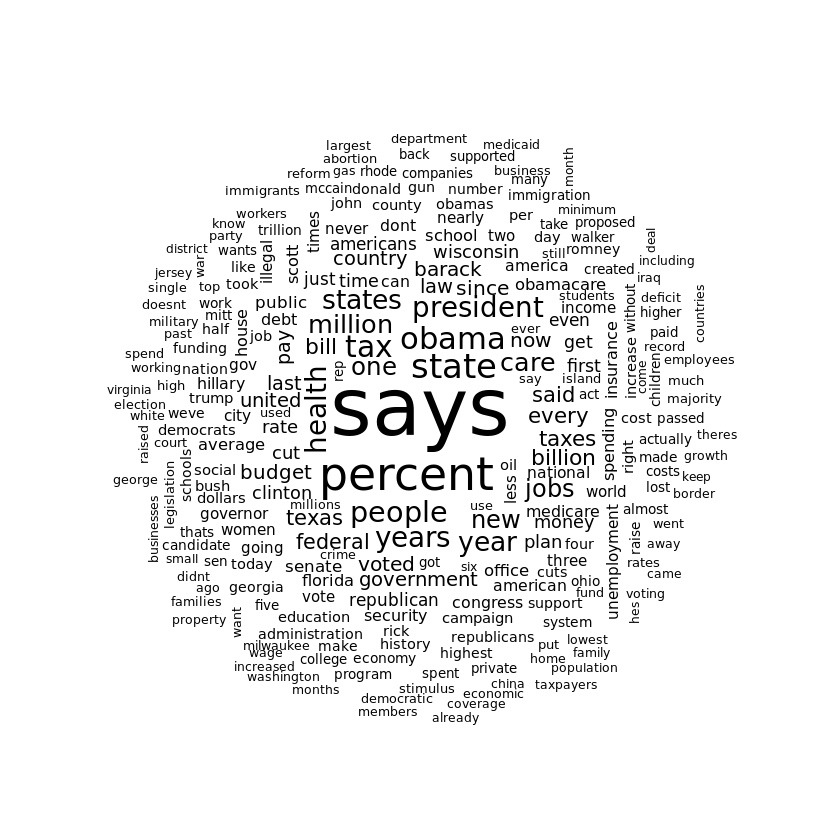

In [7]:
# term frequencies for wordcloud
train_termfreq <- termFreq(clean.split.text(train_set_raw$Text))

wordcloud(
    words = names(train_termfreq),
    freq = unname(train_termfreq),
    max.words=250,
    random.order=FALSE
)

# save word frequencies
write.csv(
    data.frame(words=names(train_termfreq), freq=unname(train_termfreq)),
    "data/train_termfreq.csv",
    row.names = FALSE
)

## Clean the training and test data

Until now the training texts have been studied and the vocabulary extracted. However, in order to use the same clean input text in all the successive studies, we create new cleaned training and test sets by using the preprocessing functions defined above.

In [8]:
train_text_clean <- character(nrow(train_set_raw))
test_text_clean <- character(nrow(test_set_raw))

for(i in seq_along(train_set_raw$Text)) {
    train_text_clean[i] <- paste(extract.vocabulary(train_set_raw[[i,"Text"]]), collapse=" ")
}
for(i in seq_along(test_set_raw$Text)) {
    test_text_clean[i] <- paste(extract.vocabulary(test_set_raw[[i,"Text"]]), collapse=" ")
}

train_set <- tibble(Labels = train_set_raw$Labels,
                    Text = train_text_clean,
                    Text_Tag = train_set_raw$Text_Tag)

test_set <-  tibble(Labels = test_set_raw$Labels,
                    Text = test_text_clean,
                    Text_Tag = test_set_raw$Text_Tag)

In [9]:
train_set

Labels,Text,Text_Tag
<dbl>,<chr>,<chr>
2,obamacare caused millions fulltime jobs become parttime,"economy,health-care,jobs"
1,cant read speech george washington without hearing reference god almighty,"pundits,religion"
5,least obama didnt marry cousin giuliani,candidates-biography
2,says reform efforts improved performance lowperforming schools palm beach florida,"city-budget,education,florida"
5,house delegates budget bill cuts million education,"corrections-and-updates,education,state-budget"
5,florida ranks last ratio employees residentsand dead nation state employee payroll expenditures per resident,state-budget
3,usage synthetic marijuana dramatically increased instances violence bodily harm even death risen,"drugs,marijuana"
3,says david dewhurst explicitly advocated guest worker program illegal immigrants,"immigration,workers"
1,new colorado law literally allows residents print ballots home computers encourages turn collectors,elections


In [10]:
test_set

Labels,Text,Text_Tag
<dbl>,<chr>,<chr>
2,decline coal start started natural gas took begin president george w bushs administration,"energy,history,job-accomplishments"
3,hillary clinton agrees john mccain voting give george bush benefit doubt iran,foreign-policy
1,health care reform legislation likely mandate free sex change surgeries,health-care
0,jim dunnam lived district represents years now,candidates-biography
2,im person stage worked actively just last year passing along russ feingold toughest ethics reform since watergate,ethics
1,mitt romney governor massachusetts didnt just slow rate growth government actually cut,"history,state-budget"
2,water rates manila philippines raised percent subsidiary world bank became partial owner,"financial-regulation,foreign-policy,water"
3,almost people left puerto rico last year,"bankruptcy,economy,population"
1,women men making less adjust inflation john kitzhaber first elected governor,"economy,income"


# General Multinomial NB Classifier, with add-one smoothing
The Multinomial Naive Bayes (NB) Classifier is a probabilistic supervised learning method. In the context of text classification, where a document $d$ needs to be assigned to a class $c \in \mathcal{C} \left( \mathcal{C}=\{c_1,c_2,\dots,c_M\} \right)$ according to its content, the learning algorithm computes a set of probabilities $P(c|d)$ to belong to a given class $c$. By assigning the occurence probability of a word $t_k$ (belonging to a dictionary $V$) within a class $c$, $P(t_k|c)$, it is possible to write a Bayesian conditional probability to compute the probabilities of interest as

$$P(c|d) \propto \prod_k P(t_k|c)\, P(c),$$

where $P(c)$ is the prior probability of a class $c$. In our implementation, $P(c)$ is estimated as the fraction of training documents that belong to class $c$. The probabilities $P(t|c)$ are instead defined as the occurence frequencies of $t$ among all the words in the documents of class $c$, i.e.,

$$P(t|c) = \dfrac{N_{tc}}{\sum_{\tau \in V} N_{\tau c}}$$.

If a single word of the dictionary does not appear in any document of class $c$, then $P(c|d)=0$ because of the Bayesian conditional probability definition. In order to avoid the vanishing of the probabilities due to the non-occurence of some words, we applied the add-one smoothing in the computation of occurence frequencies. With this smoothing, the occurence probability of a word becomes

$$P(t|c) = \dfrac{N_{tc}+1}{\sum_{\tau \in V}\left( N_{\tau c}+1 \right)},$$

which is always bigger than 0.

## Training

In [11]:
trainMultinomialNB <- function(classes, train_data, vocabulary){
    #
    # - classes: vector of (ordered) classes labels (strings or integers)
    # - train_data: tibble of training data with
    #      columns = [Labels, Text, Text_Tag]
    # - vocabulary: a function that computes the vocabulary from
    #      train_data, or the vocabulary itself if it is a vector of strings
    
    if (is.function(vocabulary)) {
        V <- vocabulary(train_data$Text)
    } else if (is.character(vocabulary)) {
        V <- vocabulary
    } else {
        V <- NULL
    }
    
    N <- nrow(train_data)

    # initialize vectors
    log_condprob <- matrix(rep(0, length(classes) * length(V)),
                           nrow = length(V), ncol = length(classes))
    prior <- rep(1, length(classes))
    wordcount <- matrix(rep(0, length(classes) * length(V)),
                        nrow = length(V), ncol = length(classes))

    for(c in seq_along(classes)) {
        # filtered training set for class c
        train_c <- train_data %>% filter(Labels == classes[c])

        # prior
        Nc <- nrow(train_c)
        prior[c] <- Nc/N

        # concatenate all texts in class c
        text_c <- train_c %>%
                  pull(Text) %>%
                  split.text()
        
        # count occurences in class c for each word in V
        wordcounts_c <- numeric(length(V))
        for(w in seq_along(V)) {
            wordcounts_c[w] <- sum(text_c == V[w])
        }
        wordcount[,c] <- wordcounts_c

        # compute conditional probability (with add-one smoothing)
        log_condprob[,c] <- log((wordcounts_c + 1) / (sum(wordcounts_c + 1)))
    }

    # output data
    out_data <- NULL
    out_data$V <- V
    out_data$prior <- prior
    out_data$log_condprob <- log_condprob
    rownames(out_data$log_condprob) <- V
    colnames(out_data$log_condprob) <- classes
    out_data$wordcount <- wordcount
    rownames(out_data$wordcount) <- V
    colnames(out_data$wordcount) <- classes

    return(out_data)
}

## Score evaluation
After the calculation of the probabilities $P(t|c)$, the score of an input text $d$ is computed with the formula

$$P(c|d) \propto \prod_k P(t_k|c)\, P(c)$$,

and the label is selected as

$$c_{MAP} = \text{argmax}\, P(c|d)$$.

In [12]:
applyMultinomialNB <- function(X, classes, V, prior, log_condprob, split_func) {
    #
    # - X: string to guess the label of
    # - classes: vector of (ordered) classes labels (strings or integers)
    # - V: dictionary obtained from the training function. A word of X
    #      that is not present into V will be ignored
    # - prior: vector of prior weights (same length as 'classes')
    #      obtained from the training function
    # - log_condprob: tibble of logarithm of conditional probabilities, with
    #      names on both rows and columns
    # - split_func: function to split X
    #

    W <- split_func(X)

    # drop entries not in V
    W <- unique(W[W %in% V])

    # sum log_condprob corresponding to all the words in W
    score <- log(prior) + apply(log_condprob[W,,drop=F], FUN = sum, MARGIN = 2)
    
    # output data
    out_data <- NULL
    out_data$score <- score
    out_data$pred_label <- classes[which.max(score)]

    return(out_data)   
}

## Accuracy evaluation

In [ ]:
# compute the accuracy and store the results
fn_accuracy <- function(train_res, test_data){

    N_correct <- 0
    predictions <- numeric(nrow(test_data))

    for (i in seq_along(test_data$Text)) {
        predictions[i] <- applyMultinomialNB(
                test_data[[i,'Text']], 
                labels, 
                train_res$V, 
                train_res$prior, 
                train_res$log_condprob, 
                split.text
            )$pred_label

        as.integer(
            predictions[i] == test_data[[i,'Labels']]
        ) + N_correct -> N_correct
    }

    # output data
    out_data <- NULL
    out_data$accuracy <- N_correct/nrow(test_data)
    out_data$predictions <- predictions

    return(out_data)
}

# Application to fake news data (without features selection)

## Training

In [13]:
fn_training <- trainMultinomialNB(
    labels,
    train_set, 
    unique.split.text
)

In [14]:
fn_training$log_condprob[1:5,]

,0,1,2,3,4,5
obamacare,-6.346911,-6.470800,-6.591056,-7.123526,-6.737814,-7.897049
caused,-10.131101,-8.392612,-8.200494,-8.828274,-8.396042,-8.484835
millions,-7.566152,-7.476321,-7.144441,-8.135127,-7.836426,-7.791688
fulltime,-9.032489,-10.184372,-8.670498,-9.521422,-9.782336,-8.707979
jobs,-6.105749,-6.073498,-5.616497,-6.171517,-6.604283,-6.567913


In [15]:
fn_training$wordcount[1:5,]

,0,1,2,3,4,5
obamacare,43,40,39,21,20,8
caused,0,5,7,3,3,4
millions,12,14,22,7,6,9
fulltime,2,0,4,1,0,3
jobs,55,60,105,56,23,33


In [16]:
# save training objectin to an R file
save(fn_training, file = "data/train_noFS.Rdata")

## Example of score evaluation

In [17]:
applyMultinomialNB(
                test_set[[2,'Text']], 
                labels, 
                fn_training$V, 
                fn_training$prior, 
                fn_training$log_condprob, 
                split.text
            )

$score
         0          1          2          3          4          5 
 -95.96643  -96.24262  -96.57260  -96.65385 -103.84038  -99.32555 

$pred_label
[1] 0

## Accuracy

In [19]:
# accuracy
fn_test <- fn_accuracy(fn_training, test_set)
cat('Accuracy:', fn_test$accuracy)

predictions <- fn_test$predictions

Accuracy: 0.2421875

In [20]:
# confusion matrix
confMatrix <- CrossTable(predictions, test_set$Labels, dnn=c('predicted','expected'))$t
dimnames(confMatrix) <- list(predicted=dimnames(confMatrix)$x,
                             expected=dimnames(confMatrix)$y)


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  2048 

 
             | expected 
   predicted |         0 |         1 |         2 |         3 |         4 |         5 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           0 |        62 |        61 |        32 |        33 |        34 |        26 |       248 | 
             |    12.155 |     2.595 |     5.041 |     3.681 |     6.163 |     6.484 |           | 
             |     0.250 |     0.246 |     0.129 |     0.133 |     0.137 |     0.105 |     0.121 | 
             |     0.188 |     0.149 |     0.082 |     0.087 |     0.185 |     0.074 |           | 
             |     0.030 |     0.030 |     0.016 |     0.016 |     0.017 |     0.013 |           | 
-------------|----

In [21]:
confMatrix

         expected
predicted   0   1   2   3   4   5
        0  62  61  32  33  34  26
        1  61  95  63  51  55  58
        2 104 132 139 108  51 102
        3  80  78 118 138  26 109
        4   3   4   1   5   8   3
        5  20  40  39  45  10  54

# Feature selection
In this section feature selection is implemented. We consider as feature utility the expected Mutual Information (MI) of the term $t$ and class $c$. We start by following a binary approach, where each document can either be in the selected class $c$ or not ($e_c=\{1, 0\}$), and can either contain the term $t$ or not  ($e_t=\{1, 0\}$). 


Mutual Information then can be estimated as:
$$
I(U, C) = 
    \frac{N_{11}}{N}\log_2\frac{N N_{11}}{N_{1.} N_{.1}} +
    \frac{N_{01}}{N}\log_2\frac{N N_{01}}{N_{0.} N_{.1}} + 
    \frac{N_{10}}{N}\log_2\frac{N N_{10}}{N_{1.} N_{.0}} +
    \frac{N_{00}}{N}\log_2\frac{N N_{00}}{N_{0.} N_{.0}} 
$$

where $Ns$ are the number of documents that have the corresponding values of $e_t$ and $e_c$ indicated by the 2 subscripts.  

In [22]:
# select features with highest importance
feature.selection <- function(classes, train_data, n_features, feature_utility, average=TRUE){
    #
    # - classes: vector of (ordered) classes labels (strings or integers)
    # - train_data: tibble of training data with
    #      columns = [Labels, Text, Text_Tag] 
    # - n_features: number of features to select
    # - feature_utility: function to compute the feature utility (e.g., MI)
    # - average: flag to select if the utily measure is computed by 
    #      averaging over the classes or not
    #

    V <- unique.split.text(train_data$Text)

    # output data
    out_data <- NULL

    if (average){
        L <- rep(0, length(V))

        for (c in classes){
            for(w in seq_along(V)) {
                L[w] <- L[w] + feature_utility(train_data, V[w], c)
            }
        }
        mask <- order(L, decreasing=TRUE)[1:n_features]
        out_data$features <- V[mask]
        out_data$utility <- L[mask]

        return(out_data)
            
    } else{
        k <- n_features %/% length(classes)
        L <- rep(0, k*length(classes))
        score <- rep(0, k*length(classes))

        for (i in seq_along(classes)){
            L_subc <- rep(0, length(V))
            for(w in seq_along(V)) {
                L_subc[w] <- feature_utility(train_data, V[w], classes[i])
            }
            mask <- order(L_subc, decreasing=TRUE)[1:k]
            L[(1+(i-1)*k):i*k] <- V[mask]
            score[(1+(i-1)*k):i*k] <- L_subc[mask]
        }
        out_data$features <- L
        out_data$utility  <- score
        return(out_data)
    }
}

# single addend of MI, given N
MI_partial <- function(N, i, j){

    # i and j con be 0 or 1, while indices 1 or 2
    i <- i+1
    j <- j+1

    N_tot <- sum(N)

    return(
        N[i,j]/N_tot*log2(
            N_tot*N[i,j]/(
                sum(N[i, ])*sum(N[,j])
            )
        )
    )
}

# mutual information
mutual.information.binary <- function(train_data, term, c){
    #
    # - c: selected class
    # - train_data: tibble of training data with
    #      columns = [Labels, Text, Text_Tag] 
    # - term: selected term
    #

    train_data_c <- train_data %>% filter(Labels == c)
    train_data_not_c <- train_data %>% filter(Labels != c)
    
    N <- matrix(rep(0, 4), nrow=2)
    
    # computation of N_tc
    for (doc in train_data_c$Text){
        if(term %in% split.text(doc)){
            # term present AND document in c  -> N_11
            N[2,2] <- N[2,2]+1
        } else{
            # term not present AND document in c  -> N_01
            N[1,2] <- N[1,2]+1
        }
    }
    for (doc in train_data_not_c$Text){
        if(term %in% split.text(doc)){
            # term present AND document not in c  -> N_10
            N[2,1] <- N[2,1]+1
        } else{
            # term not present AND document not in c  -> N_00
            N[1,1] <- N[1,1]+1
        }
    }
    
    MI <- 0
    for (i in 0:1){
        for (j in 0:1){
            MI <- MI+MI_partial(N, i, j)
        }
    }

    return(MI)
}

In [23]:
high_MI_feat <- feature.selection(labels, train_set, 100, mutual.information.binary, average=TRUE)

df_ <- data.frame(
    Features = high_MI_feat$features, 
    MI = high_MI_feat$utility
)
df_

# save feature scores
write.csv(
    df_,
    "data/train_FS_scores.csv",
    row.names = FALSE
)

Features,MI
<chr>,<dbl>
percent,0.008939579
since,0.004869406
obama,0.004638531
says,0.003975245
georgia,0.003803240
obamacare,0.003760722
rep,0.003710324
barack,0.003680394
average,0.003192581


## Training

In [24]:
fn_training_features <- trainMultinomialNB(
    labels,
    train_set, 
    df_$Features
)

In [25]:
# save training objectin to an R file
save(fn_training_features, file = "data/train_FS.Rdata")

## Accuracy

In [26]:
# accuracy
fn_test_FS <- fn_accuracy(fn_training_features, test_set)
cat('Accuracy:', fn_test_FS$accuracy)

predictions_FS <- fn_test_FS$predictions

Accuracy: 0.230957

# Use R library
Another classification attempt is performed by using the libraries available in R for text mining (`tm`) and for naiveBayes implementation (`e1071`). The input data is cleaned and the Document-Term matrix, which summarizes the occurences of each word in the training set, is computed. The function `naiveBayes`, given the input dataframe, computes the classifier. To simplify the training, only the words occurring at least 5 times are considered by the classifier.

Code adapted from the [following notebook](https://rpubs.com/drshah96/629986).

## Pre-processing using text mining package

In [27]:
# silence warnings
defaultW <- getOption("warn") 
options(warn = -1) 

# corpus definition and cleaning
train_set_corpus <- Corpus(VectorSource(train_set_raw$Text))
test_set_corpus <- Corpus(VectorSource(test_set_raw$Text))

train_set_corpus_clean <- tm_map(train_set_corpus, tolower)
test_set_corpus_clean <- tm_map(test_set_corpus, tolower)

train_set_corpus_clean <- tm_map(train_set_corpus_clean, removeNumbers)
test_set_corpus_clean <- tm_map(test_set_corpus_clean, removeNumbers)

train_set_corpus_clean <- tm_map(train_set_corpus_clean, removeWords, stopwords())
test_set_corpus_clean <- tm_map(test_set_corpus_clean, removeWords, stopwords())

train_set_corpus_clean <- tm_map(train_set_corpus_clean, removePunctuation)
test_set_corpus_clean <- tm_map(test_set_corpus_clean, removePunctuation)

train_set_corpus_clean <- tm_map(train_set_corpus_clean, stripWhitespace)
test_set_corpus_clean <- tm_map(test_set_corpus_clean, stripWhitespace)

# set back warnings
options(warn = defaultW)


In [28]:
# training wordcount
train_dtm <- DocumentTermMatrix(train_set_corpus_clean)
train_freqterms_Rlib <- findFreqTerms(train_dtm, 5)
train_dtm <- DocumentTermMatrix(train_set_corpus_clean)
train_df <- as.data.frame(as.matrix(train_dtm))
train_df <- train_df[,train_freqterms_Rlib]

# test wordcount
test_dtm <- DocumentTermMatrix(test_set_corpus_clean)
test_df <- as.data.frame(as.matrix(test_dtm))
test_df <- test_df[,train_freqterms_Rlib[train_freqterms_Rlib %in% colnames(test_df)]]

In [29]:
# save frequent terms to an R file
save(train_freqterms_Rlib, file = "data/train_freqterms_Rlib.Rdata")

In [30]:
dim(train_df)

[1] 8192 2738

In [31]:
dim(test_df)

[1] 2048 2337

In [32]:
train_df_wf <- lapply(X=train_df, FUN=function(x) factor(x, levels = c(0, 1), labels = c("No", "Yes")))
test_df_wf <- lapply(X=test_df, FUN=function(x) factor(x, levels = c(0, 1), labels = c("No", "Yes")))

## Training

In [33]:
data_classifier_wf <- naiveBayes(train_df_wf, train_set$Labels, laplace = 1)

# save training objectin to an R file
save(data_classifier_wf, file = "data/train_Rlib.Rdata")

## Accuracy

In [34]:
data_test_pred_wf <- predict(data_classifier_wf, test_df_wf[[1]], "raw")

In [43]:
confMatrix_wf <- CrossTable(predict(data_classifier_wf, test_df_wf), test_set$Labels, dnn=c('predicted','expected'))$t
dimnames(confMatrix_wf) <- list(predicted=dimnames(confMatrix_wf)$x,
                             expected=dimnames(confMatrix_wf)$y)


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  2048 

 
             | expected 
   predicted |         0 |         1 |         2 |         3 |         4 |         5 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           0 |        50 |        55 |        38 |        29 |        29 |        29 |       230 | 
             |     4.518 |     1.742 |     0.824 |     4.383 |     3.363 |     2.806 |           | 
             |     0.217 |     0.239 |     0.165 |     0.126 |     0.126 |     0.126 |     0.112 | 
             |     0.152 |     0.134 |     0.097 |     0.076 |     0.158 |     0.082 |           | 
             |     0.024 |     0.027 |     0.019 |     0.014 |     0.014 |     0.014 |           | 
-------------|----

In [44]:
confMatrix_wf

         expected
predicted   0   1   2   3   4   5
        0  50  55  38  29  29  29
        1  95 127  80  85  64  77
        2  72  89  94  76  30  71
        3  61  64 100 109  28  90
        4  13  14  15   9  15  10
        5  39  61  65  72  18  75

In [45]:
N_correct <- 0
for(i in 1:nrow(confMatrix_wf)) {
    N_correct <- N_correct + confMatrix_wf[i,i]
}

Rlib_test_accuracy <- N_correct/sum(confMatrix_wf)
cat('Accuracy:', Rlib_test_accuracy)

Accuracy: 0.2294922

# Summarize the accuracy of the models

In [52]:
Model  = c("Standard NB", "NB with FS", "NB with R lib", "Random Choice")
Accuracy = c(
    round(fn_test$accuracy, 4), 
    round(fn_test_FS$accuracy, 4), 
    round(Rlib_test_accuracy, 4), 
    round(1/6, 4)
)

df <- data.frame(Model, Accuracy)
df

Model,Accuracy
<chr>,<dbl>
Standard NB,0.2422
NB with FS,0.2310
NB with R lib,0.2295
Random Choice,0.1667


# References
[1] C. D. Manning, Chapter 13, Text Classification and Naive Bayes, in Introduction to Information
Retrieval, Cambridge University Press, 2008.

[2] Fake News Content Detection, KAGGLE data set: https://www.kaggle.com/datasets/anmolkumar/fake-news-content-detection

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c0fd424b-1528-4408-9d09-09a12c22fc52' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>